In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [2]:
import pyspark
sc = pyspark.SparkContext(appName="myAppName")
spark = (pyspark.sql.SparkSession
         .builder        
         .appName('myAppName')
         .getOrCreate()
        )

ModuleNotFoundError: No module named 'pyspark'

In [3]:
def transform_to_df(path, sep_input="\t"):
    return spark.read.csv(path,
                         header=True,       # use headers or not
                         quote='"',         # char for quotes
                         sep=sep_input,           # char for separation
                         inferSchema=True)  # do we infer schema or not ?

In [4]:
average_rating_over_year= transform_to_df("averageRating_overyear.csv", ",")

In [5]:
average_rating_over_year.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- titleId: string (nullable = true)
 |-- startYear: string (nullable = true)
 |-- averageRating: double (nullable = true)



In [18]:
movies = transform_to_df("IMDb_datasets/movies.csv", ",")

In [19]:
movies.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- titleId: string (nullable = true)
 |-- title_ordering: integer (nullable = true)
 |-- title: string (nullable = true)
 |-- region: string (nullable = true)
 |-- language: string (nullable = true)
 |-- types: string (nullable = true)
 |-- attributes: string (nullable = true)
 |-- isOriginalTitle: string (nullable = true)
 |-- titleType: string (nullable = true)
 |-- primaryTitle: string (nullable = true)
 |-- originalTitle: string (nullable = true)
 |-- isAdult: integer (nullable = true)
 |-- startYear: string (nullable = true)
 |-- endYear: string (nullable = true)
 |-- runtimeMinutes: string (nullable = true)
 |-- genres: string (nullable = true)
 |-- averageRating: double (nullable = true)
 |-- numVotes: integer (nullable = true)



In [20]:
movies.registerTempTable("movies")

In [7]:
people = transform_to_df("people_year.csv", "\t")

In [8]:
people.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- nconst: string (nullable = true)
 |-- birthYear: string (nullable = true)
 |-- primaryProfession: string (nullable = true)



In [21]:
people.registerTempTable("people")

In [11]:
principals = transform_to_df("principals.csv", ",")

In [12]:
principals.printSchema()

root
 |-- tconst: string (nullable = true)
 |-- nconst: string (nullable = true)



In [27]:
principals.show(5)

+---------+---------+
|   tconst|   nconst|
+---------+---------+
|tt1479805|nm3166689|
|tt1479992|nm0199039|
|tt1481551|nm3557069|
|tt1482567|nm0521786|
|tt1483010|nm1795989|
+---------+---------+
only showing top 5 rows



In [33]:
principals.registerTempTable("principals_t")

In [44]:
temp_table = spark.sql(
"""
SELECT DISTINCT nconst as main_nconst, birthYear,primaryProfession FROM people WHERE (primaryProfession LIKE '%actor%') or (primaryProfession LIKE '%actress%')
"""
)

In [45]:
temp_table.registerTempTable("temp_table_1")

In [46]:
pel_pri = spark.sql(
"""
SELECT * FROM temp_table_1 LEFT JOIN principals_t ON temp_table_1.main_nconst = principals_t.nconst
"""
)

In [47]:
pel_pri.printSchema()

root
 |-- main_nconst: string (nullable = true)
 |-- birthYear: string (nullable = true)
 |-- primaryProfession: string (nullable = true)
 |-- tconst: string (nullable = true)
 |-- nconst: string (nullable = true)



In [48]:
pel_pri.registerTempTable("pel_pri_t")

In [54]:
pel_pri_rating = spark.sql(
"""
SELECT * FROM pel_pri_t LEFT JOIN movies ON movies.titleId = pel_pri_t.tconst
"""
)

In [55]:
pel_pri_rating.show(2)

+-----------+---------+--------------------+---------+---------+----+-------+--------------+-----+------+--------+-----+----------+---------------+---------+------------+-------------+-------+---------+-------+--------------+------+-------------+--------+
|main_nconst|birthYear|   primaryProfession|   tconst|   nconst| _c0|titleId|title_ordering|title|region|language|types|attributes|isOriginalTitle|titleType|primaryTitle|originalTitle|isAdult|startYear|endYear|runtimeMinutes|genres|averageRating|numVotes|
+-----------+---------+--------------------+---------+---------+----+-------+--------------+-----+------+--------+-----+----------+---------------+---------+------------+-------------+-------+---------+-------+--------------+------+-------------+--------+
|  nm0001908|     1880|director,actor,pr...|tt0001170|nm0001908|null|   null|          null| null|  null|    null| null|      null|           null|     null|        null|         null|   null|     null|   null|          null|  null|

In [65]:
pel_pri_rating = spark.sql(
"""
SELECT main_nconst, birthYear, primaryProfession, tconst, startYear, averageRating FROM pel_pri_t LEFT JOIN movies ON movies.titleId = pel_pri_t.tconst
"""
)

In [58]:
pel_pri_rating.printSchema()

root
 |-- main_nconst: string (nullable = true)
 |-- birthYear: string (nullable = true)
 |-- primaryProfession: string (nullable = true)
 |-- tconst: string (nullable = true)
 |-- startYear: string (nullable = true)
 |-- averageRating: double (nullable = true)



In [66]:
pel_pri_rating.registerTempTable("pel_pri_rating_t")

In [59]:
pel_pri_rating.show(2)

+-----------+---------+--------------------+---------+---------+-------------+
|main_nconst|birthYear|   primaryProfession|   tconst|startYear|averageRating|
+-----------+---------+--------------------+---------+---------+-------------+
|  nm0001908|     1880|director,actor,pr...|tt0001170|     null|         null|
|  nm0492757|     1886|             actress|tt0001664|     null|         null|
+-----------+---------+--------------------+---------+---------+-------------+
only showing top 2 rows



In [81]:
pel_pri_rating = spark.sql(
"""
SELECT main_nconst, primaryProfession, startYear, birthYear, averageRating FROM pel_pri_rating_t WHERE startYear IS NOT NUll

"""
)

In [82]:
pd = pel_pri_rating.toPandas()

In [83]:
pd.head()

,main_nconst,primaryProfession,startYear,birthYear,averageRating
0,nm0192062,"actress,writer,director",1914,1893,5.8
1,nm0192062,"actress,writer,director",1914,1893,5.8
2,nm0192062,"actress,writer,director",1914,1893,5.8
3,nm0478359,actress,1914,1888,5.5
4,nm0478359,actress,1914,1888,5.5


In [86]:
pd_1 = pd.drop_duplicates()

In [87]:
pd_1.head()

,main_nconst,primaryProfession,startYear,birthYear,averageRating
0,nm0192062,"actress,writer,director",1914,1893,5.8
3,nm0478359,actress,1914,1888,5.5
6,nm0394389,actor,1915,1858,5.7
7,nm0071992,"actor,writer,miscellaneous",1916,1870,6.2
8,nm0366586,"actor,director,producer",1916,1864,5.3


In [90]:
pd_1 = pd_1[pd_1.startYear != "\\N"]

In [92]:
pd_1 = pd_1[pd_1.birthYear != "\\N"]

In [93]:
pd_1["age"] = pd_1["startYear"].astype("int64") - pd_1['birthYear'].astype("int64")

In [94]:
pd_2 = pd_1.drop_duplicates()

In [88]:
pd_1.size

979200

In [95]:
pd_2.size

840204

In [97]:
pwd

'/home/jovyan/work/Movies'

In [98]:
pd_2.to_csv("IMDb_datasets/age_rating.csv", sep="\t")

In [102]:
age_rating = pd.read_csv("IMDb_datasets/age_rating.csv", sep="\t")

In [104]:
age_rating.head()

,Unnamed: 0,main_nconst,primaryProfession,startYear,birthYear,averageRating,age
0,0,nm0192062,"actress,writer,director",1914,1893,5.8,21
1,3,nm0478359,actress,1914,1888,5.5,26
2,6,nm0394389,actor,1915,1858,5.7,57
3,7,nm0071992,"actor,writer,miscellaneous",1916,1870,6.2,46
4,8,nm0366586,"actor,director,producer",1916,1864,5.3,52


In [105]:
age_rating = age_rating.drop("Unnamed: 0", axis=1)

In [107]:
age_rating.size

840204

In [108]:
actors = age_rating[age_rating["primaryProfession"].apply(lambda x: 'actor' in x )]
actors.size

574716

In [118]:
actors_dropped_df = actors.drop(['main_nconst', 'primaryProfession', 'birthYear','startYear' ], axis=1)

In [128]:
actors_age_df1 = actors_dropped_df.sort_values(by=['age'])

In [141]:
actors_age_df2 = actors_age_df1[(actors_age_df1['age']>15)]

In [144]:
actors_age_df3 = actors_age_df2[(actors_age_df2['age']<100)]

In [145]:
actors_age_df = actors_age_df3.groupby('age')

In [110]:
actresses = age_rating[age_rating["primaryProfession"].apply(lambda x: 'actress' in x )]
actresses.size

265488

In [147]:
actresses_dropped_df = actresses.drop(['main_nconst', 'primaryProfession', 'birthYear','startYear' ], axis=1)
actresses_age_df1 = actresses_dropped_df.sort_values(by=['age'])
actresses_age_df2 = actresses_age_df1[(actresses_age_df1['age']>15)]
actresses_age_df3 = actresses_age_df2[(actresses_age_df2['age']<100)]
actresses_age_df = actresses_age_df3.groupby('age')

In [162]:
actors_age_df_draw = actors_age_df.apply(lambda x: x.sample(frac=0.3))
actresses_age_df_draw = actresses_age_df.apply(lambda x: x.sample(frac=0.3))

In [159]:
actors_age_df_draw.size

56754

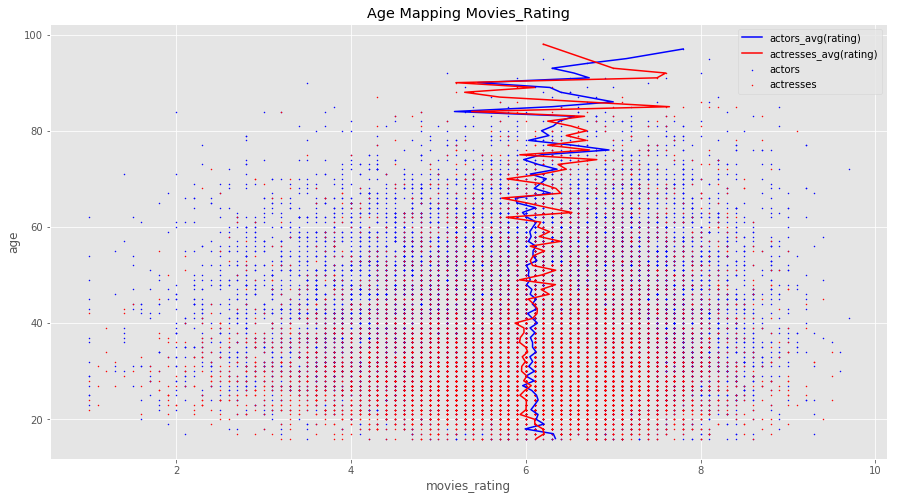

In [196]:
fig, ax = plt.subplots(figsize=(15, 8))
ax.set_title("Age Mapping Movies_Rating")
ax.set_ylabel("age")
ax.set_xlabel("movies_rating")

y_1 = actors_age_df_draw['age']
x_1 = actors_age_df_draw['averageRating']
x_1_1 = x_1.groupby('age').mean()

y_2 = actresses_age_df_draw['age']
x_2 = actresses_age_df_draw['averageRating']
x_2_2 = x_2.groupby('age').mean()

ax.scatter(x_1, y_1, s=1, c='blue', label="actors")
ax.scatter(x_2, y_2, s=1, c='red', label="actresses")

ax.plot(x_1_1, x_1_1.index, 'b', markevery=25, label="actors_avg(rating)")
ax.plot(x_2_2, x_2_2.index, 'r', markevery=25, label="actresses_avg(rating)")
ax.legend(loc='best')
plt.savefig('age_mapping_rating.png')
ax

The linear correlation mainly uses the Pearson correlation coefficient r to measure the linear correlation strength between continuous variables;
r>0, linear positive correlation; r<0, linear negative correlation;
r=0, there is no linear relationship between the two variables, and does not mean that there is no relationship between the two variables.

In [192]:
actresses['averageRating'].corr(actresses['age'])

0.037979784708851626

In [194]:
actors['averageRating'].corr(actors['age'])

-0.0019829741473593085